# Adiabatic flame temperatures

Flame temperatures depend on
* stoichiometry
* products
* fuel
* oxidizer
* enthalpy

These properties are affected by
* heat losses (radiation)
* differential diffusion
* flame strain, mixing fields
* residence time
* soot formation

**For convenience here**
* use products of complete combustion, 
* at constant pressure (1 atm), 
* with reactants at 298.15 K (25 C)
* adiabatic

**Two kinds of energy: internal, and sensible**
* Internal is energy stored in bonds
* Sensible is thermal energy
* Combustion reactants have more energy stored in chemical bonds (high internal energy) than combustion products (low internal energy). 
    * The difference is sensible energy that results in high flame temperatures.
* That is, **internal energy is released as sensible energy**

## Enthalpy, energy, C$_p$

* Considering **ideal gases**
* Total enthalpy is the sum of species enthalpies times the amount of the species.
$$H = \sum_k n_kh_k$$
$$h_k = h_{f,k}^o + \int_{T_r}^T c_{p,k}dT$$

     * $n_k$ is moles of species $k$, 
     * $H$ is total enthalpy (J), 
     * $h_k$ is enthalpy per mole (J/kmol).
     * $c_{p,k}$ is heat capacity of species $k$ (J/kmol*K)
     
* If we divide the first equation by the total number of moles we have
$$ h = \sum_k x_kh_k$$
* Insert the second equation into this:
$$ h = \sum_k h_{f,k}^o + \sum_k\int_{T_r}^Tc_{p,k}dT$$
$$ h = h_{f}^o + \int_{T_r}^Tc_pdT$$
* Here, $h_{f}^o = \sum_kh_{f,k}^o$ and $c_p = \sum_kc_{p,k}$
* All of this can be done on a mass basis too, just replace $x_k$ with $y_k$ and $n$ for $m$. Then $h_k$ is J/kg instead of J/kmol, and $c_p$ is J/kg*K instead of J/kmol*K. 
    * To convert $h_k$ from per mole to per mass, divide by the molecular weight. Same for $c_p$.
* $h_{f,k}^o$ is the heat of formation of species $k$ at 1 atm and 298.15 K. This is the enthalpy of formation from elements in their standard states.

### C$_p$
* Heat capacities are **temperature dependent**
    * Usually have a polynomial curve fit to represent $c_p(T)$.
    * Hence, enthalpy, entropy, etc. are temperature dependent.
    * $c_p$ are normalized by $R$, so the units on $c_p$ are whatever the units on the chosen $R$ are.
    * $c_p$ increases with temperature.

### Heat of reaction
* $\Delta H_{rxn} = H_{prod}-H_{react}$
    * **reactants and products at the SAME temperature**
* $\Delta H_{rxn} < 0$ since combustion reactions are exothermic.
* $\Delta H_{comb} = -\Delta H_{rxn}$, so heats of combustion are positive.
* Usually reported per mole of fuel, or per kg of fuel (be careful).

### Heating values: LHV, HHV
* As a basis for the amount of heat that can be extracted from combustion, the higher heating value (HHV) and lower heating value LHV are used.
* The HHV treats product $H_2O$ as a liquid.
* The LHV treats product $H_2O$ as a vapor.
* These use products of complete combustion at 298.15 K and 1 atm.
* **See Turns Table B1.**


## T$_{ad}$ for CH$_4$

$$CH_4 + 2O_2 + 7.52N_2 \rightarrow CO_2 + 2H_2O + 7.52 N_2$$

$H_R(298.15\, K) = H_P(T_{ad})$
* This is one equation in one unknown.
* The reactant and product compositions are known. The reactant temperature is known, so the reactant enthalpy is known.
* Solve $T_{ad}$.

$$H_R = H_P(T_{ad})$$
$$H_P(T_{ad}) = 1\mbox{ mole}\cdot h_{CO2}(T_{ad}) + 2\cdot h_{H2O}(T_{ad}) + 7.52\cdot h_{N2}(T_{ad})$$

* Turns Table A.13 gives $h_{k}(T)$ as polynomial expressions:
$$\frac{h_{k}(T)}{RT} = a_1 + \frac{a_2}{2}T + \frac{a_3}{3}T^2 + \frac{a_4}{4}T^3 + \frac{a_5}{5}T^4 + \frac{a_6}{T}$$
    * where a different set of coefficients $a$ are used for each species $k$
* We insert these expressions for $h_k(T)$ into the equation for $H_P(T_{ad})$ and solve for $T_{ad}$.

#### Set some data and make a ```thermo``` class for convenience

In [46]:
import yaml
import numpy as np
from scipy.optimize import fsolve

########################################################################
# Thermo data from Cantera's gri30.cti file

thermoData = '''
Tlow:  200
Tmid:  1000
Thigh: 3500

CH4:
    a_lo: [  5.149876130E+00,  -1.367097880E-02, 4.918005990E-05,  -4.847430260E-08,   1.666939560E-11,-1.024664760E+04,  -4.641303760E+00]
    a_hi: [  7.485149500E-02,   1.339094670E-02, -5.732858090E-06,   1.222925350E-09,  -1.018152300E-13,-9.468344590E+03,   1.843731800E+01]
O2:
    a_lo: [  3.782456360E+00,  -2.996734160E-03, 9.847302010E-06,  -9.681295090E-09,   3.243728370E-12,-1.063943560E+03,   3.657675730E+00]
    a_hi: [  3.282537840E+00,   1.483087540E-03, -7.579666690E-07,   2.094705550E-10,  -2.167177940E-14,-1.088457720E+03,   5.453231290E+00]
N2:
    a_lo: [  3.298677000E+00,   1.408240400E-03, -3.963222000E-06,   5.641515000E-09,  -2.444854000E-12,-1.020899900E+03,   3.950372000E+00]
    a_hi: [  2.926640000E+00,   1.487976800E-03, -5.684760000E-07,   1.009703800E-10,  -6.753351000E-15,-9.227977000E+02,   5.980528000E+00]
CO2:
    a_lo: [  2.356773520E+00,   8.984596770E-03, -7.123562690E-06,   2.459190220E-09,  -1.436995480E-13,-4.837196970E+04,   9.901052220E+00]
    a_hi: [  3.857460290E+00,   4.414370260E-03, -2.214814040E-06,   5.234901880E-10,  -4.720841640E-14,-4.875916600E+04,   2.271638060E+00]
H2O:
    a_lo: [  4.198640560E+00,  -2.036434100E-03, 6.520402110E-06,  -5.487970620E-09,   1.771978170E-12,-3.029372670E+04,  -8.490322080E-01]
    a_hi: [  3.033992490E+00,   2.176918040E-03, -1.640725180E-07,  -9.704198700E-11,   1.682009920E-14,-3.000429710E+04,   4.966770100E+00]
'''

########################################################################

class thermo():

    def __init__(self, species) :
        """
        species: input, string name of species in thermoData.yaml
        M: input (species molecular weight, kg/kmol)
        Call as: h2o = thermo("H2O"), then get enthalpy as h2o.h_mole(298.15), etc.
        """

        s = self

        #tData = open("thermoData.yaml"); tData = yaml.load(tData)
        tData = yaml.load(thermoData)

        s.a_lo = tData[species]["a_lo"]
        s.a_hi = tData[species]["a_hi"]

        s.T_lo = tData["Tlow"]
        s.T_mid = tData["Tmid"]
        s.T_hi = tData["Thigh"]

    #--------------------------------------------------------

    def h_mole(self,T) :
        """
        T: input, (K)
        return enthalpy in units of J/kmol
        """
        s = self
        
        if T<=s.T_mid and T>=s.T_lo :
            a = s.a_lo
        elif T>s.T_mid and T<=s.T_hi :
            a = s.a_hi
        else :
            raise ValueError("ERROR: temperature is out of range")

        hRT = a[0] + a[1]/2.0*T + a[2]/3.0*T*T + a[3]/4.0*T**3.0 + a[4]/5.0*T**4.0 + a[5]/T

        return hRT * 8314.46 * T 

#### Calculate T$_{ad}$ 

In [44]:
ch4 = thermo("CH4")
o2  = thermo("O2")
n2  = thermo("N2")
co2 = thermo("CO2")
h2o = thermo("H2O")

Tr = 298.15
Hr = ch4.h_mole(Tr)  + 2*o2.h_mole(Tr)   + 7.52*n2.h_mole(Tr)

def F(Tad):
    Hp = co2.h_mole(Tad) + 2*h2o.h_mole(Tad) + 7.52*n2.h_mole(Tad)
    return Hr - Hp

Tad = fsolve(F, Tad_guess)[0]

print("Adiabatic flame temperature =", Tad, "K")

Adiabatic flame temperature = 2325.59812975 K


## Do the same thing using Cantera instead

In [56]:
import cantera as ct
gas = ct.Solution("gri30.yaml")
P = 101325   # Pa

#----------- Stoichiometric reactants
Tr = 298.15
gas.TPX = Tr, P, "CH4:1, O2:2, N2:7.52"
hR = gas.enthalpy_mass

#----------- Stoichiometric products
gas.HPX = hR, P, "CO2:1, H2O:2, N2:7.52"       # note, enthalpy is reactant enthalpy
yst = gas.Y
print("Tad =", gas.T, "K")


Tad = 2325.5981297600447 K


## Compute T$_{ad}$ over all $\xi$ using Cantera

* Species mass fractions are peicewise linear.
    * That is, the lean compositions are linear between $\xi=0$ and stoichiometric, and the rich compositions are linear between $\xi=\xi_{st}$ and $\xi=1$.
    * So, find the mass fractions at $\xi=0$, $\xi=\xi_{st}$, and $\xi=1$.
* Lean:
    * $(y-y_0)/(\xi-0) = (y_{st} - y_0)/(\xi_{st}-0)$
    * $\rightarrow y = y_0 + (y_{st} - y_0)\xi/\xi_{st}.$
* Rich:
    * $(y-y_{st})/(\xi-\xi_{st}) = (y_1 - y_{st})/(1-\xi_{st})$
    * $\rightarrow y = y_{st} + (y_1 - y_{st})(\xi-\xi_{st})/(1-\xi_{st})$
    
* Enthalpy is a conserved scalar, so 
    * $h = h_0\cdot(1-\xi) + h_1\cdot(\xi)$

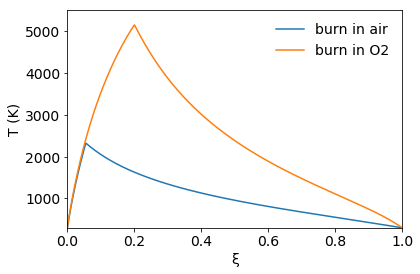

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

#########################################################

def Tad_all_mixf(oxidizer, fuel, stoicReac, stoicProd, plotLabel):
    '''
    Plot Tad versus mixture fraction
    oxidizer,  input, dictionary of species names and moles
    fuel,      input, dictionary of species names and moles
    stoicReac, input, dictionary of species names and moles
    stoicProd, input, dictionary of species names and moles
    plotLabel, input, string for the plot label
    '''
    
    species = ["CH4", "O2", "N2", "CO2", "H2O"]

    #--------- Get the state at ξ = 0
    gas.TPX = 298.15, P, oxidizer
    y0 = gas.Y
    h0 = gas.enthalpy_mass 
    
    #--------- Get the state at ξ = 1
    gas.TPX = 298.15, P, fuel
    y1 = gas.Y
    h1 = gas.enthalpy_mass
    
    #----------- Stoichiometric products
    gas.X = stoicProd
    yst = gas.Y
    
    #--------- Get Tad at all ξ
    
    ξ_st = gas.molecular_weights[gas.species_index("CH4")] * stoicReac["CH4"]/ (          
           gas.molecular_weights[gas.species_index("CH4")] * stoicReac["CH4"] + 
           gas.molecular_weights[gas.species_index("O2")]  * stoicReac["O2"] +
           gas.molecular_weights[gas.species_index("N2")]  * stoicReac["N2"])
    
    n = 1000
    ξ = np.linspace(0.0,1,n)
    T = np.zeros(n)
    
    for i in range(n):
        if ξ[i] <= ξ_st:
            y = y0 + (yst-y0)*ξ[i]/ξ_st
        else:
            y = yst + (y1-yst)*(ξ[i]-ξ_st)/(1-ξ_st)
        h = h0*(1-ξ[i]) + h1*ξ[i]
        gas.HPY = h, P, y
        T[i] = gas.T
        
    #--------- Plot results
        
    plt.rc('font', size=14)
    plt.plot(ξ,T, label=plotLabel)
    plt.xlabel('ξ')
    plt.ylabel('T (K)')
    plt.xlim([0,1])
    plt.ylim([298.15,5500])
    plt.legend(frameon=False);
    
#########################################################

#---- Do combustion in air

oxidizer  = {"O2":1, "N2":3.76}
fuel      = {"CH4":1}
stoicReac = {"CH4":1, "O2":2, "N2":7.52}
stoicProd = {"CO2":1, "H2O":2, "N2":7.52}

Tad_all_mixf(oxidizer, fuel, stoicReac, stoicProd, 'burn in air')

#---- Do combustion in o2

oxidizer  = {"O2":1, "N2":0}
fuel      = {"CH4":1}
stoicReac = {"CH4":1, "O2":2, "N2":0}
stoicProd = {"CO2":1, "H2O":2, "N2":0}

Tad_all_mixf(oxidizer, fuel, stoicReac, stoicProd, 'burn in O2')